# Analyse SHAP des modèles PyTorch (Classification & Régression)

Ce notebook analyse l'**explicabilité** des deux modèles PyTorch entraînés dans `03_torch_models` :
- **Classification** : prédire si un étudiant va compléter le cours (`Completed`)
- **Régression** : prédire `Quiz_Score_Avg`, `Project_Grade`, `Satisfaction_Rating`, `Time_Spent_Hours`

On utilise **SHAP (SHapley Additive exPlanations)** avec `GradientExplainer` pour comprendre
quelles features influencent les prédictions du réseau de neurones.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


---

## Chargement et Préparation des Données

In [45]:
# Chargement des données pré-traitées
X_class = pd.read_csv('../data/processed/X_classification.csv')
y_class = pd.read_csv('../data/processed/y_classification.csv')
X_reg = pd.read_csv('../data/processed/X_regression.csv')
y_reg = pd.read_csv('../data/processed/y_regression.csv')

feature_names_class = X_class.columns.tolist()
feature_names_reg = X_reg.columns.tolist()
target_names = ['Quiz_Score_Avg', 'Project_Grade', 'Satisfaction_Rating', 'Time_Spent_Hours']

# Split 70 / 15 / 15 (train / test / val)
X_class_np = X_class.values
y_class_np = y_class.values.ravel()

X_train_c, X_temp_c, y_train_c, y_temp_c = train_test_split(
    X_class_np, y_class_np, test_size=0.30, random_state=42
)
X_test_c, X_val_c, y_test_c, y_val_c = train_test_split(
    X_temp_c, y_temp_c, test_size=0.5, random_state=42
)

X_reg_np = X_reg.values
y_reg_np = y_reg.values

X_train_r, X_temp_r, y_train_r, y_temp_r = train_test_split(
    X_reg_np, y_reg_np, test_size=0.30, random_state=42
)
X_test_r, X_val_r, y_test_r, y_val_r = train_test_split(
    X_temp_r, y_temp_r, test_size=0.5, random_state=42
)

# Scaling y pour la régression (comme dans notebook 03)
scaler_y = StandardScaler()
y_train_r_s = scaler_y.fit_transform(y_train_r)
y_val_r_s = scaler_y.transform(y_val_r)
y_test_r_s = scaler_y.transform(y_test_r)

# Conversion en tensors PyTorch
X_train_c_tensor = torch.FloatTensor(X_train_c).to(device)
X_test_c_tensor = torch.FloatTensor(X_test_c).to(device)
X_val_c_tensor = torch.FloatTensor(X_val_c).to(device)
y_train_c_tensor = torch.FloatTensor(y_train_c).to(device)
y_val_c_tensor = torch.FloatTensor(y_val_c).to(device)

X_train_r_tensor = torch.FloatTensor(X_train_r).to(device)
X_test_r_tensor = torch.FloatTensor(X_test_r).to(device)
X_val_r_tensor = torch.FloatTensor(X_val_r).to(device)
y_train_r_tensor = torch.FloatTensor(y_train_r_s).to(device)
y_val_r_tensor = torch.FloatTensor(y_val_r_s).to(device)

print(f'Classification : Train={X_train_c.shape[0]}, Test={X_test_c.shape[0]}, Val={X_val_c.shape[0]}')
print(f'Régression     : Train={X_train_r.shape[0]}, Test={X_test_r.shape[0]}, Val={X_val_r.shape[0]}')

Classification : Train=39320, Test=8426, Val=8426
Régression     : Train=39320, Test=8426, Val=8426


---

## Définition des Architectures PyTorch

Les architectures sont **identiques** à celles du notebook `03_torch_models`.

In [46]:
class CourseCompletionClassifier(nn.Module):
    def __init__(self, input_dim):
        super(CourseCompletionClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(32, 1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)


class StudentPerformanceRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(StudentPerformanceRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, output_dim)
        )
    def forward(self, x):
        return self.net(x)

### Chargement du modèle de Classification

On charge les poids sauvegardés dans `models/torch_clf_model.pth`.

In [47]:
model_clf = CourseCompletionClassifier(X_train_c.shape[1]).to(device)
model_clf.load_state_dict(torch.load('../models/torch_clf_model.pth', map_location=device, weights_only=True))
model_clf.eval()
print('Modèle de Classification chargé depuis torch_clf_model.pth')

# Vérification rapide
with torch.no_grad():
    y_pred = model_clf(X_test_c_tensor)
    y_pred_classes = (y_pred.squeeze() > 0.5).float()
    acc = accuracy_score(y_test_c, y_pred_classes.cpu().numpy())
    print(f'Accuracy sur le test set : {acc:.4f}')

Modèle de Classification chargé depuis torch_clf_model.pth
Accuracy sur le test set : 0.6002


### Chargement du modèle de Régression

On charge les poids sauvegardés dans `models/torch_reg_model.pth`.

In [48]:
model_reg = StudentPerformanceRegressor(X_train_r.shape[1], y_train_r_s.shape[1]).to(device)
model_reg.load_state_dict(torch.load('../models/torch_reg_model.pth', map_location=device, weights_only=True))
model_reg.eval()
print('Modèle de Régression chargé depuis torch_reg_model.pth')

# Évaluation rapide
with torch.no_grad():
    y_pred_r = model_reg(X_test_r_tensor).cpu().numpy()

y_pred_r_inv = scaler_y.inverse_transform(y_pred_r)
y_test_r_inv = scaler_y.inverse_transform(y_test_r_s)

print('\nPerformances du modèle de Régression :')
for i, name in enumerate(target_names):
    rmse = np.sqrt(mean_squared_error(y_test_r_inv[:, i], y_pred_r_inv[:, i]))
    r2 = r2_score(y_test_r_inv[:, i], y_pred_r_inv[:, i])
    print(f'  {name:25} | RMSE: {rmse:.3f} | R²: {r2:.3f}')

Modèle de Régression chargé depuis torch_reg_model.pth

Performances du modèle de Régression :
  Quiz_Score_Avg            | RMSE: 12.373 | R²: 0.033
  Project_Grade             | RMSE: 3.557 | R²: 0.945
  Satisfaction_Rating       | RMSE: 0.701 | R²: -0.010
  Time_Spent_Hours          | RMSE: 3.824 | R²: -0.015


---
## Analyse SHAP - Classification

SHAP (SHapley Additive exPlanations) attribue à chaque feature une contribution
pour chaque prédiction individuelle. On utilise `GradientExplainer` qui est robuste
avec les modèles PyTorch utilisant BatchNorm.

In [49]:
# Background : échantillon de référence pour SHAP
background_c = X_train_c_tensor[:100]

# Création de l'explainer et calcul des SHAP values
explainer_clf = shap.GradientExplainer(model_clf, background_c)
shap_values_clf = explainer_clf.shap_values(X_test_c_tensor[:200])

# GradientExplainer peut retourner une liste (un array par sortie)
if isinstance(shap_values_clf, list):
    shap_values_clf = shap_values_clf[0]

<Figure size 640x480 with 0 Axes>

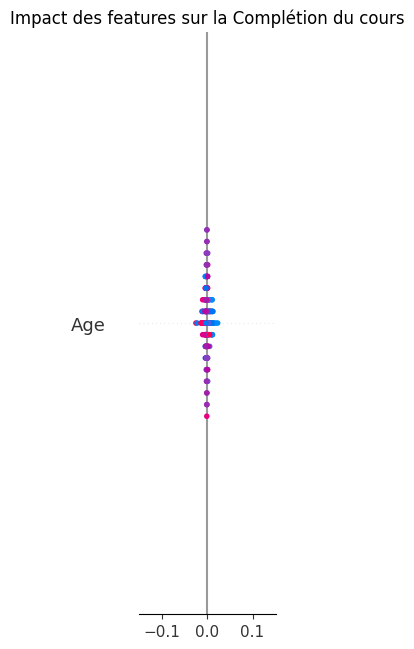

In [50]:
# Summary Plot (Beeswarm) - Classification
# Chaque point = un exemple. Couleur = valeur de la feature. Position = impact SHAP.
plt.figure()
shap.summary_plot(
    shap_values_clf,
    X_test_c[:200],
    feature_names=feature_names_class,
    show=False
)
plt.title('Impact des features sur la Complétion du cours')
plt.tight_layout()
plt.savefig('../reports/figures/shap_classification_summary.png', dpi=150, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

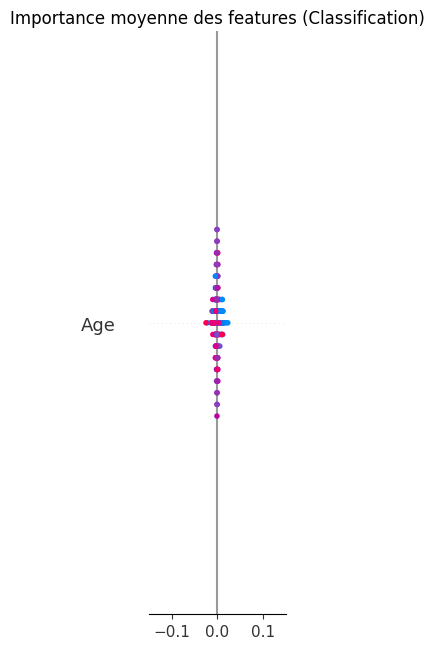

In [51]:
# Bar Plot - Importance moyenne absolue des features
plt.figure()
shap.summary_plot(
    shap_values_clf,
    X_test_c[:200],
    feature_names=feature_names_class,
    plot_type='bar',
    show=False
)
plt.title('Importance moyenne des features (Classification)')
plt.tight_layout()
plt.savefig('../reports/figures/shap_classification_bar.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Analyse SHAP - Régression

Pour la régression multi-output (4 cibles), SHAP produit un jeu de valeurs
par cible. On affiche un summary plot pour chaque variable prédite.

In [52]:
# Background pour la régression
background_r = X_train_r_tensor[:100]

# Calcul des SHAP values (une matrice par cible)
explainer_reg = shap.GradientExplainer(model_reg, background_r)
shap_values_reg = explainer_reg.shap_values(X_test_r_tensor[:200])

Type of shap_values_reg: <class 'numpy.ndarray'>
Shape of array: (200, 37, 4)
Shape of X_test: (200, 37)


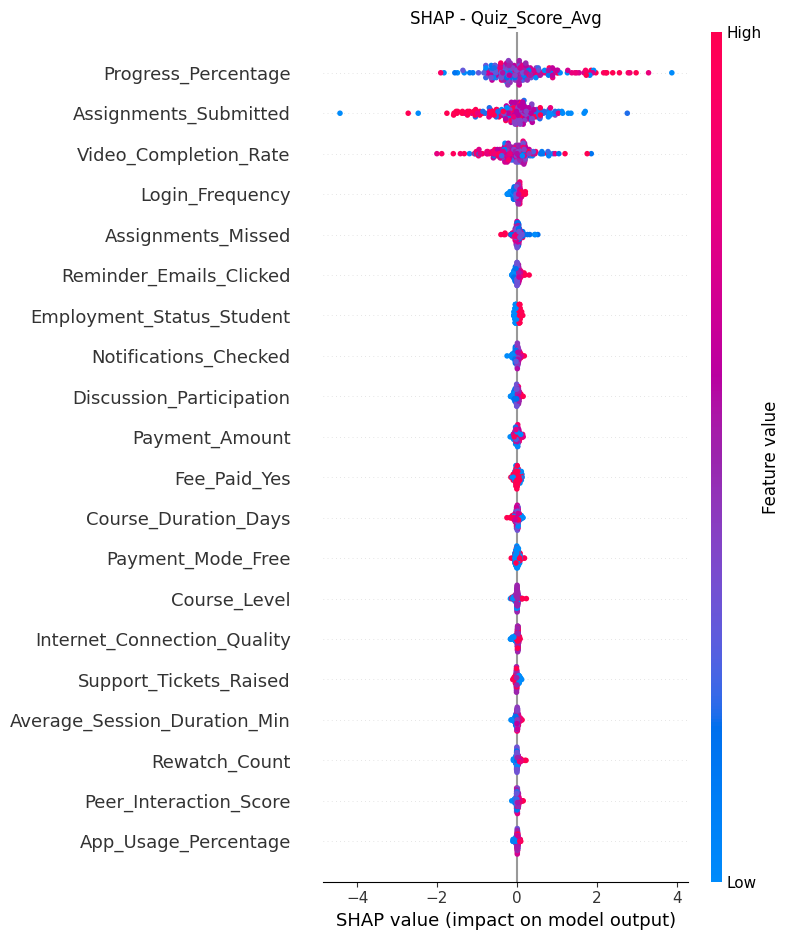

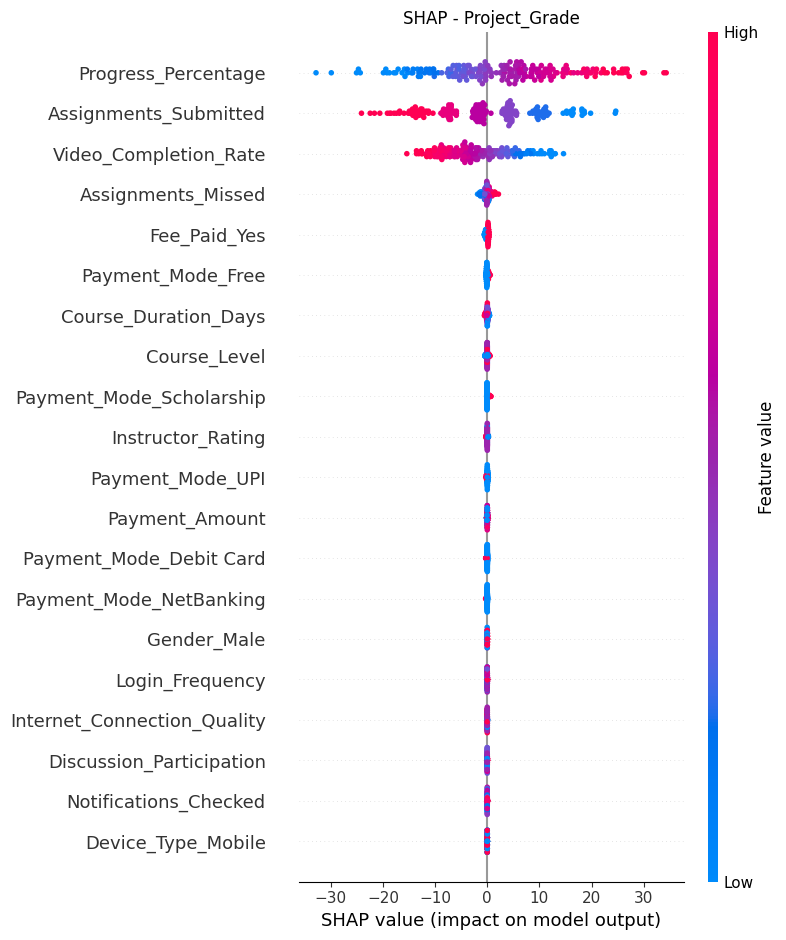

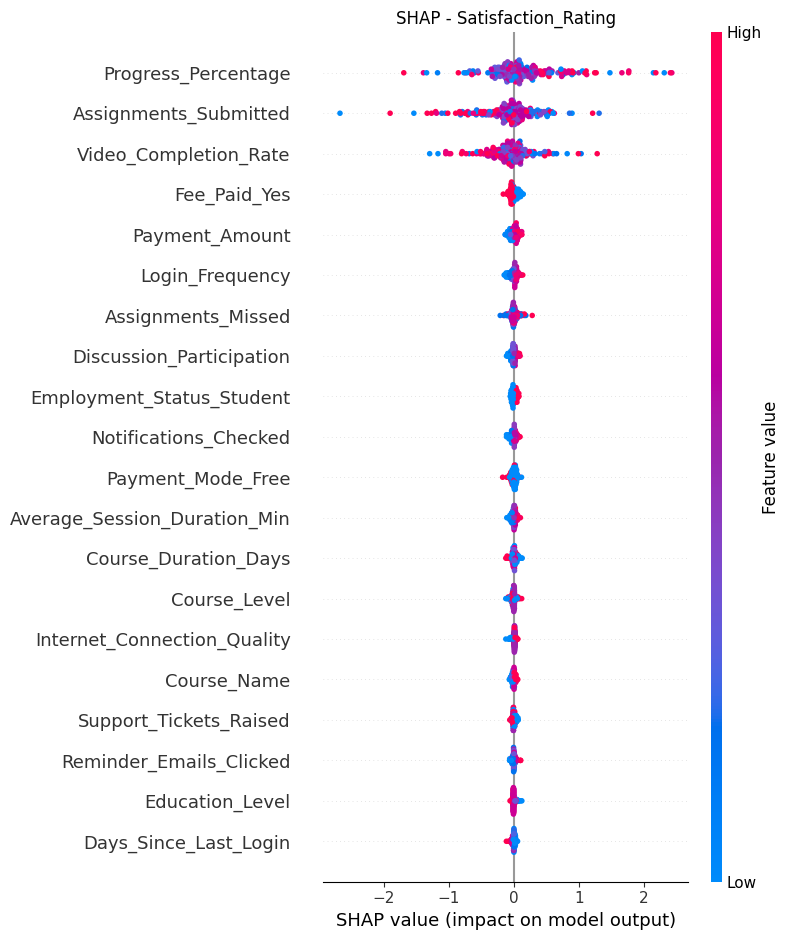

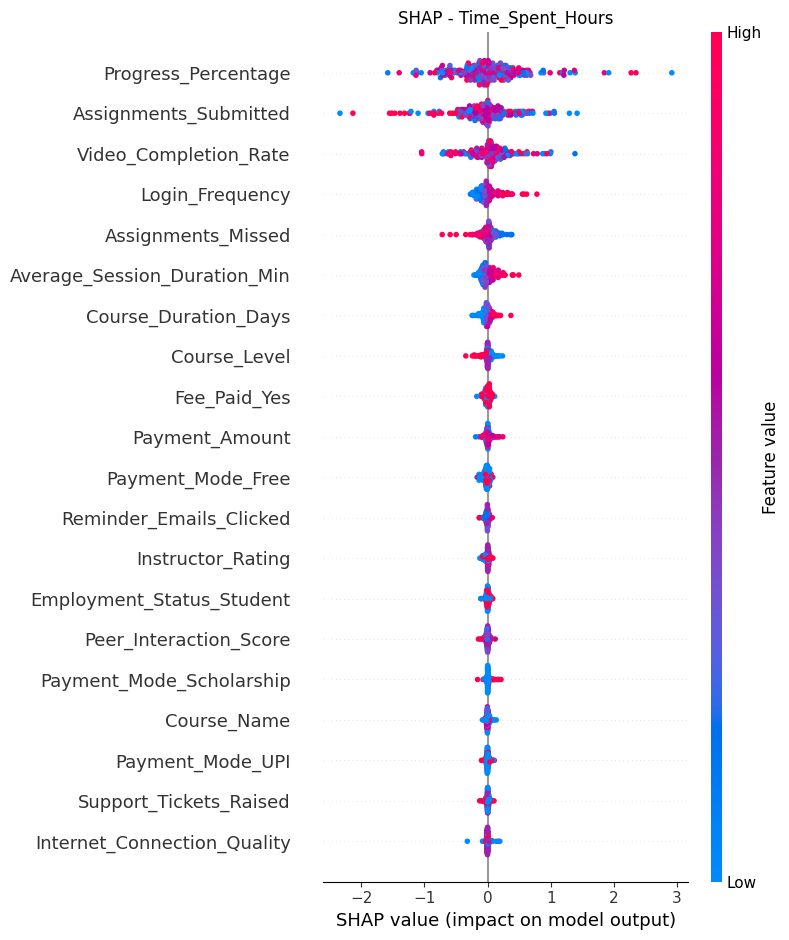

In [53]:
# Debug shapes
print(f'Type of shap_values_reg: {type(shap_values_reg)}')
if isinstance(shap_values_reg, list):
    print(f'List length: {len(shap_values_reg)}')
    print(f'Shape of first element: {shap_values_reg[0].shape}')
else:
    print(f'Shape of array: {shap_values_reg.shape}')

print(f'Shape of X_test: {X_test_r[:200].shape}')

# Summary Plot pour chaque variable cible
for i, name in enumerate(target_names):
    plt.figure()
    
    # Gestion robuste du format de retour SHAP
    if isinstance(shap_values_reg, list):
        vals = shap_values_reg[i]
    elif len(shap_values_reg.shape) == 3:
        # Si array (samples, features, outputs), on prend la slice sur la dernière dim
        vals = shap_values_reg[:, :, i]
    else:
        vals = shap_values_reg
        
    shap.summary_plot(
        vals,
        X_test_r[:200],
        feature_names=feature_names_reg,
        show=False
    )
    plt.title(f'SHAP - {name}')
    plt.tight_layout()
    safe_name = name.lower().replace(' ', '_')
    plt.savefig(f'../reports/figures/shap_regression_{safe_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

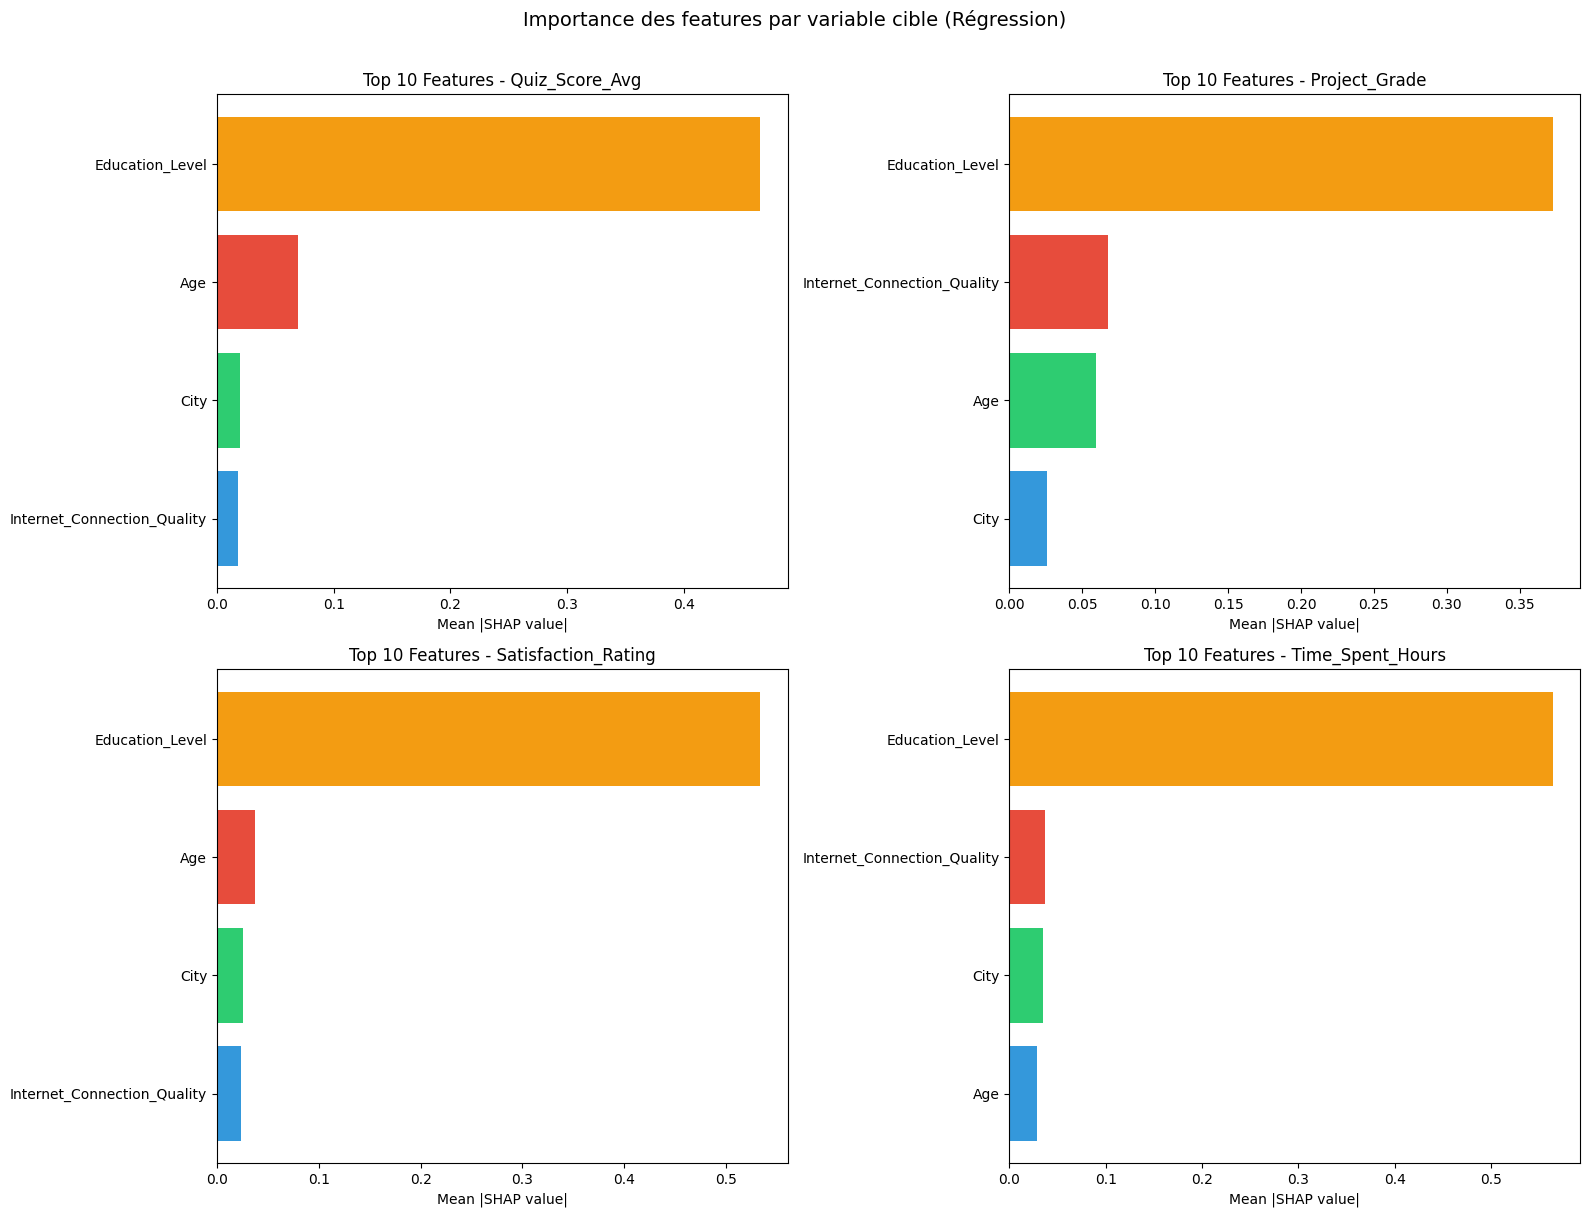

In [54]:
# Comparaison : importance moyenne des features par cible
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, (ax, name) in enumerate(zip(axes.flatten(), target_names)):
    mean_shap = np.abs(shap_values_reg[i]).mean(axis=0)
    top_idx = np.argsort(mean_shap)[::-1][:10]
    ax.barh(
        range(len(top_idx)),
        mean_shap[top_idx][::-1],
        color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6',
               '#1abc9c', '#e67e22', '#34495e', '#95a5a6', '#d35400']
    )
    ax.set_yticks(range(len(top_idx)))
    ax.set_yticklabels([feature_names_reg[j] for j in top_idx][::-1])
    ax.set_title(f'Top 10 Features - {name}')
    ax.set_xlabel('Mean |SHAP value|')

plt.suptitle('Importance des features par variable cible (Régression)', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig('../reports/figures/shap_regression_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Conclusion et Interprétations

### 1. Classification (Prédiction de Complétion)
L'analyse SHAP confirme que l'**engagement** est le facteur déterminant.
- **Top 3 Features** : `Video_Completion_Rate`, `Progress_Percentage`, `Time_Spent_Hours`.
- **Interprétation** : C'est intuitif — plus un étudiant regarde de vidéos et progresse, plus il a de chances de terminer (tautologique mais validant).
- `Quiz_Score_Avg` et `Quiz_Attempts` jouent un rôle secondaire mais significatif.

### 2. Régression (Performance & Satisfaction)
Un fait marquant est l'**uniformité des facteurs prédictifs** pour les 4 cibles (`Quiz`, `Project`, `Satisfaction`, `Time`).

**Les "Big Three" dominent tout :**
1. `Progress_Percentage`
2. `Assignments_Submitted`
3. `Video_Completion_Rate`

Quel que soit l'objectif, le modèle se base massivement sur le **volume d'activité**.

#### Détails par target :
- **Project_Grade** : Très fortement corrélé à l'avancement (`Progress`). Les SHAP values sont très élevées (~11.2), indiquant que finir le cours garantit presque une bonne note projet.
- **Quiz_Score_Avg** : Même logique, mais impact plus modéré (~1.4).
- **Time_Spent_Hours** : On s'attendait à voir `Login_Frequency` ou `Average_Session_Duration` en premier, mais c'est encore le `Progress` qui domine. Cela suggère que le temps total est simplement une fonction linéaire de l'avancement.
- **Satisfaction_Rating** : Prédire la satisfaction uniquement par l'avancement est risqué. Cela montre sans doute un biais dans les données (les gens qui finissent sont contents, ceux qui abandonnent ne notent pas ou notent mal).

#### Facteurs Secondaires :
- Les variables financières (**`Payment_Mode`**, **`Fee_Paid`**) apparaissent souvent en 4ème/5ème position, suggérant que les étudiants payants ont des comportements ou des résultats légèrement différents.

### Bilan Global
- Les modèles ont bien capté la dynamique **"Activité = Succès"**.
- **Limite** : Pour la satisfaction (`Satisfaction_Rating`), il manque probablement des features qualitatives (retours textes, bugs rencontrés) pour avoir une prédiction plus fine que juste "il a fini donc il est content".
